In [1]:
# code from https://github.com/Pehlevan-Group/TD-RL-dynamics/blob/main/TD_dynamics_theory_curves.ipynb
# to understand theory

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import jax.numpy as jnp
from jax import random, lax, vmap
import jax
#jax.config.update("jax_enable_x64", True)

In [3]:
def sqrt_mat(A):
    s, v = jnp.linalg.eigh(A)
    s_sqrt = s**(0.5) * (s>0.0)
    return v @ jnp.diag(s_sqrt) @ v.T 

In [4]:
# define MDP for random exploration
box_len = 21
# take in (x,y) coordinate and output new (x',y')
def update_fn(coord_key,x):
    coord, key = coord_key
    key_x, key_y,key_filt = random.split(key,3)
    x, y = coord
    
    dx = 2 * random.choice(key_x, 2) -1 # dx in {-1,1}
    dy = 2 * random.choice(key_y, 2) -1 # dx in {-1,1}
    
    filt = random.choice(key_filt, 2) # update only x or y but not both!
    new_key,_ = random.split(key_x)
    new_x = x + filt * dx
    new_y = y + (1-filt)*dy
    
    # now map to boundary, takes care of edge case
    new_x = (new_x>=box_len)*(x-1) + (new_x<0)*(x+1) + new_x *(new_x<box_len)*(new_x>=0)
    new_y = (new_y>=box_len)*(y-1) + (new_y<0)*(y+1) + new_y *(new_y<box_len)*(new_y>=0)

    new_coord = [ new_x, new_y ]
    return [new_coord, new_key], coord

In [5]:
_,coords = lax.scan(update_fn, [[box_len//2,box_len//2], random.PRNGKey(0)], None, length = 50)

2023-11-16 17:30:47.735596: W pjrt_plugin/src/mps_client.cc:535] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [6]:
num_samples = 10
get_coords = lambda seed: lax.scan(update_fn, [[box_len//2,box_len//2], random.PRNGKey(seed)], None, length = 100)[1]
all_coords = vmap(get_coords)(jnp.arange(num_samples))

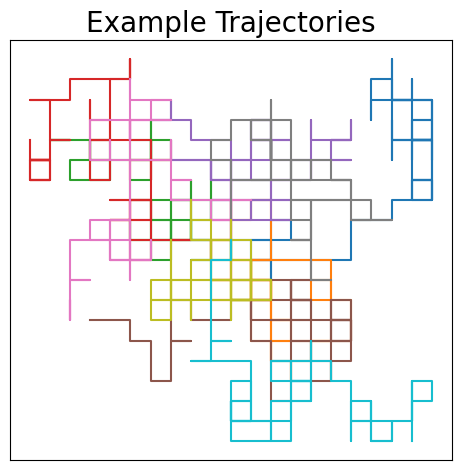

In [7]:
plt.figure()
for i in range(num_samples):
    plt.plot(all_coords[0][i,:],all_coords[1][i,:])
plt.xticks([])
plt.yticks([])
plt.title('Example Trajectories',fontsize = 20)
plt.gca().set_aspect('equal')
plt.tight_layout()
#plt.savefig('figures/explore_2d_mdp.pdf', bbox_inches = 'tight')
plt.show()

In [8]:
def compute_transition_mat():
    Pi = np.zeros((box_len, box_len, box_len, box_len)) # (x,y), (x',y') is probability of going (x',y')->(x,y)
    
    # bulk: simple transition
    for i in range(1,box_len-1):
        for j in range(1,box_len-1):
            Pi[i+1,j,i,j] = 0.25
            Pi[i-1,j,i,j] = 0.25
            Pi[i,j-1,i,j] = 0.25
            Pi[i,j+1,i,j] = 0.25
    
    bm = box_len-1
    # edge conditions: bounce-back condition
    for i in range(1, box_len-1):
        Pi[1,i,0,i] = 0.5
        Pi[0,i+1,0,i] = 0.25
        Pi[0,i-1,0,i] = 0.25
        
        Pi[i,1,i,0] = 0.5
        Pi[i+1,0,i,0]=0.25
        Pi[i-1,0,i,0] =0.25
        
        Pi[bm-1,i,bm,i] = 0.5
        Pi[bm,i+1,bm,i] = 0.25
        Pi[bm,i-1,bm,i] = 0.25
        
        Pi[i,bm-1,i,bm] = 0.5
        Pi[i+1,bm,i,bm] = 0.25
        Pi[i-1,bm,i,bm] = 0.25
    
    # corner conditions
    Pi[0,1,0,0] = 0.5
    Pi[1,0,0,0] = 0.5
    
    Pi[bm,1,bm,0] = 0.5
    Pi[bm-1,0,bm,0] = 0.5
    
    Pi[1,bm,0,bm] = 0.5
    Pi[0,bm-1,0,bm] = 0.5
    
    Pi[bm-1,bm,bm,bm] = 0.5
    Pi[bm,bm-1,bm,bm] = 0.5
    return Pi

In [9]:
Pi = compute_transition_mat()
Pi = jnp.array(Pi)
print(Pi.shape)
print(Pi[:5,:5,0,0])
print(Pi[:5,:5,2,2])

(21, 21, 21, 21)
[[0.  0.5 0.  0.  0. ]
 [0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.  ]
 [0.   0.25 0.   0.25 0.  ]
 [0.   0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.  ]]


In [10]:
# compute two_point probability P(s_t= s, s_{t'} = s')
T = 50

powers_of_Pi = []
Pit = 1.0 * jnp.einsum('ik,jl->ijkl', jnp.eye(box_len), jnp.eye(box_len)) # identity map base case Pi^0
for t in range(T):
    powers_of_Pi += [ Pit  ]
    Pit = jnp.einsum('ijkl,klnm->ijnm',Pi, Pit)

In [11]:
# compute r_i[x,y] the neural code
# we will use a place cell code
def construct_code(sigma=2.5):
    N = box_len**2
    R = np.zeros((N,box_len,box_len))
    grid = np.linspace(0,box_len-1,box_len)
    for i in range(box_len):
        for j in range(box_len):
            dx2 = (grid - i)**2
            dy2 = (grid - j)**2
            dist = dx2[:,np.newaxis] + dy2[np.newaxis,:]
            R[i*box_len + j,:,:] = np.exp(-0.5 * dist/sigma**2)
    
    return R - R.mean(axis = (1,2))[:,np.newaxis,np.newaxis]

def construct_code_from_K(sigma=2.5):
    
    K = np.zeros((box_len, box_len, box_len, box_len))
    grid = np.linspace(0,box_len-1,box_len)
    for i in range(box_len):
        for j in range(box_len):
            dx2 = (grid - i)**2
            dy2 = (grid - j)**2
            dist = dx2[:,np.newaxis] + dy2[np.newaxis,:]
            K[i,j,:,:] = np.exp(-0.5/sigma**2 * dist )
    
    K_flat = K.reshape((K.shape[0]**2, K.shape[2]**2))
    s, v = jnp.linalg.eigh(K_flat)
    s = s * (s > 0.0 )
    indsort = jnp.argsort(s)[::-1]
    s = s[indsort]
    v = v[:,indsort]
    Psi_flat = jnp.diag(jnp.sqrt(s)) @ v.T # neurons x space
    Psi = Psi_flat.reshape((Psi_flat.shape[0], K.shape[2], K.shape[3]))
    return Psi



def construct_target_fn(sigma=2.5, dist_mult=1):
    
    R = np.zeros((box_len,box_len))
    grid = np.linspace(0,box_len-1,box_len)
    i = box_len//2 + dist_mult*box_len//5
    j = box_len//2 + dist_mult*box_len//5

    dx2 = (grid - i)**2
    dy2 = (grid - j)**2
    dist = dx2[:,np.newaxis] + dy2[np.newaxis,:]
    R = np.exp(-0.5 * dist/sigma**2)
    return R - R.mean()

Psi = construct_code()
#Psi = construct_code_from_K()
N = Psi.shape[0]
R = construct_target_fn()

print(Psi.shape)
print(R.shape)
print(N)

(441, 21, 21)
(21, 21)
441


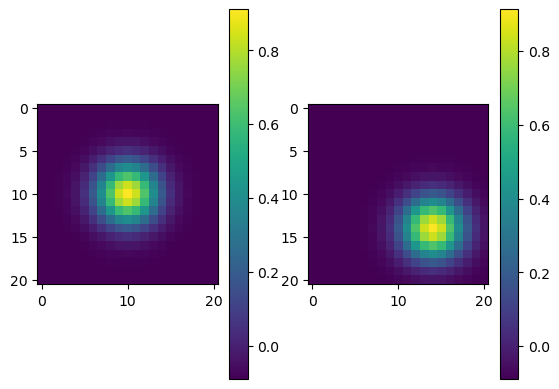

In [12]:
plt.figure()
plt.subplot(121)
plt.imshow(Psi[220])
plt.colorbar()

plt.subplot(122)
plt.imshow(R)
plt.colorbar()


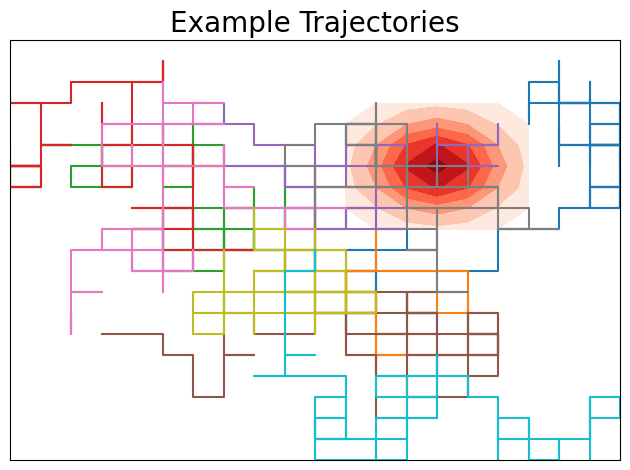

In [13]:
plt.figure()
R_plot = construct_target_fn(sigma = 1.5)
R_plot2 = np.zeros(R_plot.shape)
for i in range(R_plot.shape[0]):
    for j in range(R_plot.shape[1]):
        if R_plot[i,j] > 0.0:
            R_plot2[i,j] = R_plot[i,j]
        else:
            R_plot2[i,j] = np.nan

plt.contourf(R_plot2,cmap='Reds')
for i in range(num_samples):
    plt.plot(all_coords[0][i,:],all_coords[1][i,:])
#R_plot = R * (R>0.0) 

plt.xticks([])
plt.yticks([])
plt.title('Example Trajectories',fontsize = 20)
plt.tight_layout()
#plt.savefig('figures/explore_2d_mdp_w_reward.pdf', bbox_inches = 'tight')
plt.show()

In [14]:
samples = 5200
T = 51
get_coords = lambda seed: lax.scan(update_fn, [[box_len//2,box_len//2], random.PRNGKey(seed)], None, length = T)[1]
all_coords = vmap(get_coords)(jnp.arange(samples))

In [15]:
print( all_coords[0].shape)
print(all_coords[1].shape )
Psi_visits = Psi[:,all_coords[0],all_coords[1]] # should be like N x samples x T
print(Psi_visits.shape)
print(Psi.shape)

(5200, 51)
(5200, 51)
(441, 5200, 51)
(441, 21, 21)


In [17]:
Sigma_emp = 1/Psi_visits.shape[1] * jnp.einsum('ijk,ljm->iklm', Psi_visits, Psi_visits)
print(Sigma_emp.dtype)
Sigma_emp = jnp.array(Sigma_emp, dtype= jnp.float32)
Sigma_flat = Sigma_emp.reshape((Sigma_emp.shape[0]*Sigma_emp.shape[1], Sigma_emp.shape[0]*Sigma_emp.shape[1]))
sqrt_Sigma = sqrt_mat(Sigma_flat)
sqrt_Sigma= sqrt_Sigma.reshape(Sigma_emp.shape)
print(Sigma_emp.shape)
print(Sigma_flat.shape)

print("symmetry check")
print( jnp.amax( ( Sigma_flat.T - Sigma_flat)**2 ) )

float32


NotImplementedError: MLIR translation rule for primitive 'eigh' not found for platform METAL

In [ ]:
A = jnp.ones((10,10), dtype = jnp.float64)
sqrt_A = sqrt_mat(A)


In [ ]:
plt.imshow( Sigma_emp[5,:,5,:],cmap = 'coolwarm')
plt.show()

In [ ]:
# train with Sigma_emp and compare to training with actual sampling
# R is reward function
def TD_MDP(eta, gamma, R, batch = 10, num_steps = 500, sigma = 0.0):

    # compute wR, wV
    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    print("max sv of Psi")
    print(jnp.amax(s))
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-8*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    print(jnp.mean(wV**2))
    sample_nums = jnp.arange(batch)
    w = jnp.zeros(wR.shape[0])
    
    print(w.shape)
    print(wR.shape)
    print(wV.shape)
    print(Psi.shape)
    
    losses = []
    for n in range(num_steps):   
        loss = jnp.dot( (w-wV), Sigma_bar @ (w-wV) )
        losses += [loss]

        all_coords = vmap(get_coords)(sample_nums)
        sample_nums += jnp.ones(sample_nums.shape[0], dtype=jnp.int32) * sample_nums.shape[0]
        
        Psi_vis = Psi[:,all_coords[0],all_coords[1]] # N x B x T
        Psi0 = Psi_vis[:,:,:-1]
        Psi1 = Psi_vis[:,:,1:]
        
        RPE = jnp.einsum('ijk,i->jk', Psi0 ,wR-w) + gamma * jnp.einsum('ijk,i->jk', Psi1 ,w) + sigma * random.normal(random.PRNGKey(n), (Psi0.shape[1],Psi0.shape[2]))
        w = w + eta/batch * jnp.einsum('ijk,jk->i', Psi0, RPE)
    return losses


In [ ]:
def TD_Gauss(eta, gamma, R, batch = 10, num_steps = 500, sigma = 0.0):

    # compute wR, wV
    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-8*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    sample_nums = jnp.arange(batch)
    w = jnp.zeros(wR.shape[0])
        
    key = random.PRNGKey(0)
    losses = []
    
    for n in range(num_steps):   
        loss = jnp.dot( (w-wV), Sigma_bar @ (w-wV) )
        losses += [loss]
        Z = random.normal(key,(N,T,batch)) # 
        Psi_vis = jnp.einsum('ijkl,klm->imj', sqrt_Sigma, Z) # N x B x T

        key, _ = random.split(key)
        
        #all_coords = vmap(get_coords)(sample_nums)
        #sample_nums += jnp.ones(sample_nums.shape[0], dtype=jnp.int32) * sample_nums.shape[0]
        
        Psi0 = Psi_vis[:,:,:-1]
        Psi1 = Psi_vis[:,:,1:]
        
        RPE = jnp.einsum('ijk,i->jk', Psi0 ,wR-w) + gamma * jnp.einsum('ijk,i->jk', Psi1 ,w) + sigma * random.normal(random.PRNGKey(n), (Psi0.shape[1],Psi0.shape[2]))
        w = w + eta/batch * jnp.einsum('ijk,jk->i', Psi0, RPE)
        
    return losses

In [ ]:
def TD_theory_MDP(eta, gamma, R, batch = 10, num_steps = 500, sigma = 0.0):
    
    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    
    print("minimum eigenvalue of Sigma_bar")
    print(jnp.amin(jnp.linalg.eigvalsh(Sigma_bar)))
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-8*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    N = wV.shape[0]
    
    # average weight
    wbar = jnp.zeros(N)

    # error covariance
    M = jnp.outer(wV,wV)
    
    A = jnp.eye(N) - eta * ( Sigma_bar - gamma*Sigma_bar_shift )
    
    Sigma0 = Sigma_emp[:,:-1,:,:-1]
    Sigma1 = Sigma_emp[:,:-1,:,1:]
    Sigma2 = Sigma_emp[:,1:,:,1:]
    
    losses = [ ]
    for n in range(num_steps):
        
        losses += [ jnp.sum( M * Sigma_bar ) ]
        ww = M + jnp.outer(wbar-wV,wV) + jnp.outer(wV, wbar-wV) + jnp.outer(wV,wV)
        w_wR_sqr = ww - jnp.outer(wbar,wR) - jnp.outer(wR,wbar) + jnp.outer(wR,wR)
        w_wR_cross = jnp.outer(wR,wbar) - ww
        
        
        
        Q = jnp.einsum('ijkl,ik->jl', Sigma0, w_wR_sqr) # calculate
        Q += gamma * jnp.einsum('ijkl,ik->jl', Sigma1, w_wR_cross) + gamma * jnp.einsum('ijkl,ik->lj', Sigma1, w_wR_cross)
        Q += gamma**2 * jnp.einsum('ijkl,ik->jl', Sigma2, ww)
        Q += sigma**2 * jnp.eye(Q.shape[0])
        
        M = A @ M @ A.T + eta**2 / batch * jnp.einsum('ijkl,jl->ik', Sigma0, Q)
        wbar = wbar + eta * ( Sigma_bar - gamma*Sigma_bar_shift ) @ (wV - wbar)
        
    return losses

In [ ]:

eta = 0.01
gamma = 0.8
losses_MDP = TD_MDP(eta, gamma, R)
losses_Gauss = TD_Gauss(eta, gamma, R)
losses_th = TD_theory_MDP(eta, gamma, R)

In [ ]:
plt.rcParams.update({'font.size': 14})

length = len(losses_MDP)
plt.loglog(np.linspace(1,length,length), np.array(losses_MDP) / losses_MDP[0], label = 'MDP')
plt.loglog(np.linspace(1,length,length), np.array(losses_Gauss) / losses_Gauss[0], '--', label = 'Gaussian')
plt.loglog(np.linspace(1,length,length), np.array(losses_th) / losses_th[0], '--', color = 'black', label = 'Theory')
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('figures/value_err_2d_explore_mdp_gaussequiv.pdf')
plt.show()